In [18]:
import numpy as np
import pandas as pd
import torch
import nilearn as nil
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import OneHotEncoder
import nilearn.plotting
import nibabel as nib
import matplotlib.pyplot as plt

## Load the Haxby dataset

In [19]:
import os
import warnings
warnings.filterwarnings(action='once')
from nilearn.input_data import NiftiMasker

from nilearn import datasets 
from nilearn.image import load_img
# We are fetching the data for subject 4
# data_dir = os.path.join('..', 'data')
sub_no = 4
haxby_dataset = datasets.fetch_haxby(subjects=[sub_no], fetch_stimuli=True, data_dir='/scratch/cl6707/Projects/neuro_interp/data')
func_file = haxby_dataset.func[0]

# Standardizing
# mask_vt_file = haxby_dataset.mask_vt[0]
# masker = NiftiMasker(mask_img=mask_vt_file, standardize=True)

# cognitive annotations
import pandas as pd
behavioral = pd.read_csv(haxby_dataset.session_target[0], delimiter=' ')
# X = masker.fit_transform(func_file)
X = load_img(func_file).get_fdata().transpose(3,0,1,2)
y = behavioral['labels']


In [20]:
# creating instance of one-hot-encoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
categories = behavioral['labels'].unique()
enc = OneHotEncoder(categories= [categories] , handle_unknown='ignore')
y_onehot = enc.fit_transform(np.array(y).reshape(-1, 1)).toarray()
# turn the sparse matrix into a pandas dataframe
# y = pd.DataFrame(y_onehot.toarray())
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size = 0.2, random_state = 42) 
bs = 1024
dataset_train = torch.utils.data.TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train.astype(np.float32)))
dataset_test = torch.utils.data.TensorDataset(torch.tensor(X_test.astype(np.float32)), torch.tensor(y_test.astype(np.float32)))

dataloaders = {'train': torch.utils.data.DataLoader(dataset_train, batch_size=bs, shuffle=True, num_workers=1),
                'val': torch.utils.data.DataLoader(dataset_test, batch_size=bs, shuffle=True, num_workers=1)}


In [21]:
for i_batch, sample_batched in enumerate(dataloaders['train']):
    print(i_batch, sample_batched[0].size(),
          sample_batched[1].size())
    break

/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()


0 torch.Size([1024, 40, 64, 64]) torch.Size([1024, 9])


## Model Define

In [22]:
import torch.nn as nn
import torch.nn.functional as F

class DownsamplingNet(nn.Module):
    def __init__(self,c):
        super(DownsamplingNet, self).__init__()
        
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm3d(32)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm3d(64)
        self.conv3 = nn.Conv3d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm3d(128)
        self.conv4 = nn.Conv3d(128, c, kernel_size=[5,8,8], stride=1, padding=0)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.conv4(x)
        return x

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

class light_conv_net(nn.Module):
    def __init__(self, f_dim=128):
        super(light_conv_net, self).__init__()
        self.downsample = DownsamplingNet( f_dim)
        self.out_mlp = MLP(f_dim, f_dim//2, 9)
    
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.downsample(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        return self.out_mlp(x)


## Train the model

In [23]:
# train the model
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import time
import copy

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, device='cpu'):
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    val_loss_history = []
    train_loss_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            
            running_loss = 0.0
            running_corrects = 0
            
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = dataloaders['train']
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = dataloaders['val']
            
            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs,labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == torch.max(labels, 1)[1])
            
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects / len(dataloader.dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # Save loss and accuracy for plotting
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            else:
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                print('Saving best model')
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'best_model.pt')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
         time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    # model.load_state_dict(best_model_wts)
    # model.load_state_dict(torch.load('best_model.pt'))
    return model, val_acc_history, train_acc_history, val_loss_history, train_loss_history

Model = light_conv_net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Model.parameters(), lr=0.001)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cuda" if torch.cuda.is_available() else "cpu"
Model.to(device)
Model, val_acc_history, train_acc_history, val_loss_history, train_loss_history = train_model(Model, dataloaders, criterion, optimizer, num_epochs=20, device=device)   


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0/19
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()


train Loss: 3.5921 Acc: 0.1266


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()
  5%|▌         | 1/20 [00:04<01:18,  4.11s/it]

val Loss: 3.1297 Acc: 0.4227
Saving best model

Epoch 1/19
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()


train Loss: 2.8761 Acc: 0.3609


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()
 10%|█         | 2/20 [00:08<01:14,  4.15s/it]

val Loss: 3.5687 Acc: 0.0447

Epoch 2/19
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()


train Loss: 2.6494 Acc: 0.1258


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()
 15%|█▌        | 3/20 [00:12<01:10,  4.17s/it]

val Loss: 6.0811 Acc: 0.0550

Epoch 3/19
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()


train Loss: 3.1431 Acc: 0.1059


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()
 20%|██        | 4/20 [00:16<01:05,  4.08s/it]

val Loss: 4.5508 Acc: 0.4227

Epoch 4/19
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()


train Loss: 2.5454 Acc: 0.3652


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()
 25%|██▌       | 5/20 [00:20<01:00,  4.02s/it]

val Loss: 4.0671 Acc: 0.1168

Epoch 5/19
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()


train Loss: 2.5985 Acc: 0.0637


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()
 30%|███       | 6/20 [00:24<00:55,  3.99s/it]

val Loss: 5.0398 Acc: 0.4227

Epoch 6/19
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()


train Loss: 2.5920 Acc: 0.4005


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()
 35%|███▌      | 7/20 [00:28<00:51,  3.99s/it]

val Loss: 2.7154 Acc: 0.0550

Epoch 7/19
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()


train Loss: 2.2388 Acc: 0.0792


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()
 40%|████      | 8/20 [00:32<00:47,  3.98s/it]

val Loss: 2.2009 Acc: 0.4227

Epoch 8/19
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()


train Loss: 2.1268 Acc: 0.4005


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()
 45%|████▌     | 9/20 [00:36<00:43,  3.96s/it]

val Loss: 2.9074 Acc: 0.4227

Epoch 9/19
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()


train Loss: 2.1082 Acc: 0.4005


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()
 50%|█████     | 10/20 [00:40<00:39,  3.94s/it]

val Loss: 1.9509 Acc: 0.4227

Epoch 10/19
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()


train Loss: 1.9870 Acc: 0.4005


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()
 55%|█████▌    | 11/20 [00:43<00:35,  3.94s/it]

val Loss: 2.1830 Acc: 0.4227

Epoch 11/19
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()


train Loss: 2.0335 Acc: 0.4005


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()
 60%|██████    | 12/20 [00:47<00:31,  3.92s/it]

val Loss: 1.9150 Acc: 0.4227

Epoch 12/19
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()


train Loss: 1.9845 Acc: 0.4005


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()
 65%|██████▌   | 13/20 [00:51<00:27,  3.94s/it]

val Loss: 2.0459 Acc: 0.4227

Epoch 13/19
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()


train Loss: 1.9942 Acc: 0.4005


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()
 70%|███████   | 14/20 [00:55<00:23,  3.93s/it]

val Loss: 1.9767 Acc: 0.4227

Epoch 14/19
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()


train Loss: 2.0085 Acc: 0.4005


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()
 75%|███████▌  | 15/20 [00:59<00:19,  3.94s/it]

val Loss: 2.0006 Acc: 0.4227

Epoch 15/19
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()


train Loss: 1.9841 Acc: 0.4005


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()
 80%|████████  | 16/20 [01:03<00:15,  3.94s/it]

val Loss: 1.9146 Acc: 0.4227

Epoch 16/19
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()


train Loss: 1.9865 Acc: 0.4005


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()
 85%|████████▌ | 17/20 [01:07<00:11,  3.96s/it]

val Loss: 1.9869 Acc: 0.4227

Epoch 17/19
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()


train Loss: 1.9871 Acc: 0.4005


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()
 90%|█████████ | 18/20 [01:11<00:07,  3.94s/it]

val Loss: 1.9246 Acc: 0.4227

Epoch 18/19
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()


train Loss: 1.9842 Acc: 0.4005


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()
 95%|█████████▌| 19/20 [01:15<00:03,  3.95s/it]

val Loss: 1.9080 Acc: 0.4227

Epoch 19/19
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()


train Loss: 1.9746 Acc: 0.4005


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc118054ca0>
  self.pid = os.fork()
100%|██████████| 20/20 [01:19<00:00,  3.98s/it]

val Loss: 1.9272 Acc: 0.4227

Training complete in 1m 20s
Best val Acc: 0.422680


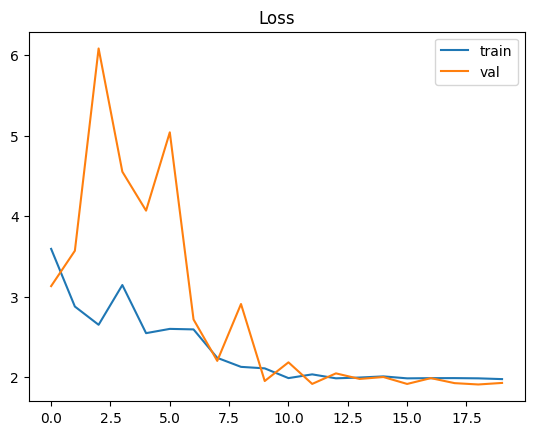

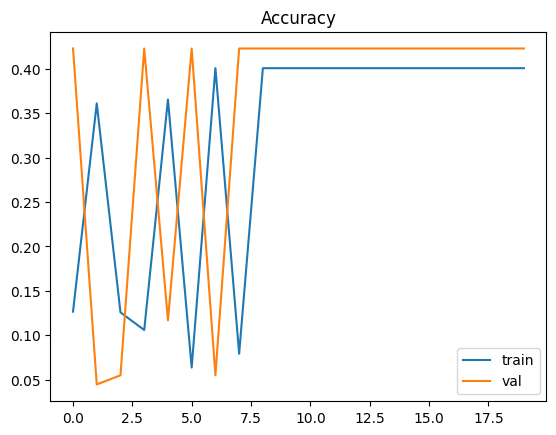

In [24]:
plt.figure(0)
plt.title('Loss')
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='val')
plt.legend()
plt.show()

plt.figure(1)
plt.title('Accuracy')
plt.plot([acc.cpu().numpy() for acc in train_acc_history], label='train')
plt.plot([acc.cpu().numpy() for acc in val_acc_history], label='val')
plt.legend()
plt.show()


## Todo: Visualization with Grad-CAM on 3d fMRI